# Evaluation

In [54]:
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import pandas as pd
import seaborn as sns
import requests

SCHEMALESS_URL = "http://localhost:5001/solr/articles/select"
SCHEMA_URL = "http://localhost:5002/solr/articles/select"


In [109]:
# METRICS TABLE
# Define custom decorator to automatically calculate metric based on key
metrics = {}
def metric(f): return metrics.setdefault(f.__name__, f)


@metric
def ap(results, relevant):
    """Average Precision"""
    precision_values = [
        len([
            doc
            for doc in results[:idx]
            if doc in relevant
        ]) / idx
        for idx in range(1, len(results))
    ]
    if len(precision_values) == 0:
        return 0
    return sum(precision_values)/len(precision_values)


@metric
def p10(results, relevant, n=10):
    """Precision at N"""
    return len([doc for doc in results[:n] if doc in relevant])/n


@metric
def re(results, relevant):
    """Recall"""
    return len([doc for doc in results if doc in relevant])/len(relevant)


def calculate_metric(key, results, relevant):
    return metrics[key](results, relevant)


# Define metrics to be calculated
evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)',
    're': 'Recall',
}


def _parse_articles(articles):
    return list(map(lambda x: "{}/{}/{}".format(x["book"], x["key"], x["date"]), articles))


def metrics_table(search_results, qrels_results):
    # Calculate all metrics and export results as LaTeX table
    df = pd.DataFrame([['Metric', 'Value']] +
                      [
        [evaluation_metrics[m], calculate_metric(
            m, search_results, qrels_results)]
        for m in evaluation_metrics
    ]
    )

    print(df)


def precision_recall_display(search_results, qrels_results):
    # PRECISION-RECALL CURVE
    # Calculate precision and recall values as we move down the ranked list
    precision_values = [
        len([
            doc
            for doc in search_results[:idx]
            if doc in qrels_results
        ]) / idx
        for idx, _ in enumerate(search_results, start=1)
    ]

    recall_values = [
        len([
            doc for doc in search_results[:idx]
            if doc in qrels_results
        ]) / len(qrels_results)
        for idx, _ in enumerate(search_results, start=1)
    ]

    precision_recall_match = {k: v for k,
                              v in zip(recall_values, precision_values)}

    # Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
    recall_values.extend([step for step in np.arange(
        0.1, 1.1, 0.1) if step not in recall_values])
    recall_values = sorted(set(recall_values))

    # Extend matching dict to include these new intermediate steps
    for idx, step in enumerate(recall_values):
        if step not in precision_recall_match:
            if recall_values[idx-1] in precision_recall_match:
                precision_recall_match[step] = precision_recall_match[recall_values[idx-1]]
            else:
                precision_recall_match[step] = precision_recall_match[recall_values[idx+1]]

    disp = PrecisionRecallDisplay(
        [precision_recall_match.get(r) for r in recall_values], recall_values)
    disp.plot()


def precision_order_display(search_results, qrels_results, size=10):
    res = []
    for list_size in range(1, size+1):
        precision = p10(search_results, qrels_results, list_size)
        res.append(precision)

    grid = sns.relplot(data=res, kind="line")
    grid.set_titles("Precision at N").set_axis_labels("Size", "Precision")
    grid.set(xlim=(0, size), ylim=(0, 1))
    return grid


def recall_order_display(search_results, qrels_results, size=10):
    res = []
    for list_size in range(1, size+1):
        new_results = search_results[:list_size]
        recall = re(new_results, qrels_results)
        res.append(recall)

    grid = sns.relplot(data=res, kind="line")
    grid.set_titles("Recall at N").set_axis_labels("Size", "Recall")
    grid.set(xlim=(0, size), ylim=(0, 1))
    return grid

def statistics(title, search_results, qrels_results):
    print(title)
    search_results = _parse_articles(search_results)
    metrics_table(search_results, qrels_results)
    if (len(search_results) > 0):
        pre = precision_order_display(search_results, qrels_results)
        re = recall_order_display(search_results, qrels_results)
        pre.savefig(f"{title} precision.pdf")
        re.savefig(f"{title} recall.pdf")


## Articles containing "horas extraordinárias"

general search schemaless
                        0      1
0                  Metric  Value
1       Average Precision    0.0
2  Precision at 10 (P@10)    0.0
3                  Recall    0.0
general search schema without weights
                        0        1
0                  Metric    Value
1       Average Precision  0.02512
2  Precision at 10 (P@10)      0.3
3                  Recall      1.0
general search schema with weights
                        0        1
0                  Metric    Value
1       Average Precision  0.02512
2  Precision at 10 (P@10)      0.3
3                  Recall      1.0


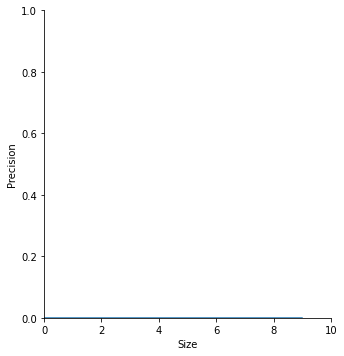

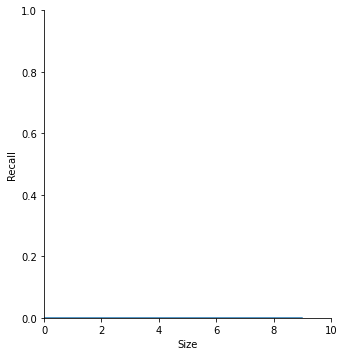

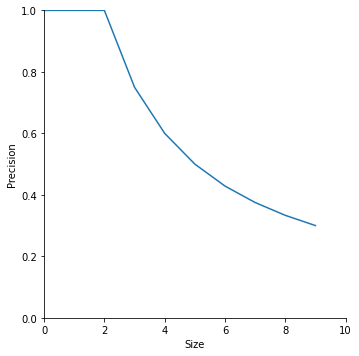

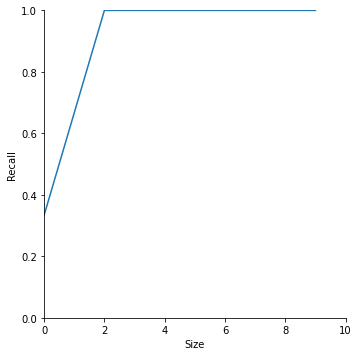

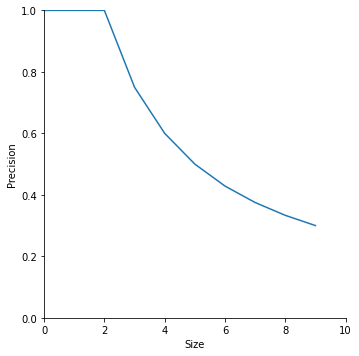

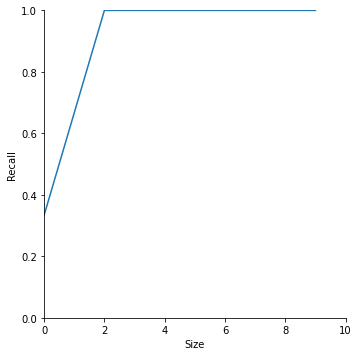

In [111]:
# you've got to do this manually
# for this example I searched for "horas extraordinárias" in the regular file
# and these IDs are "book/key/date"
qrels = [
    "Código Penal/58/1995-03-15T00:00:00Z",
    "Código Penal/58/2017-11-21T00:00:00Z",
    "Código Penal/58/2007-09-15T00:00:00Z",
]

# schemaless
schemaless_results = requests.get(
    SCHEMALESS_URL,
    params={
        "defType": "edismax",
        "qf": "title text path book",
        "pf": "title text path book",
        "q": "horas extraordinárias",
        "start": 0,
        "rows": 1000
    }
).json()['response']['docs']

# schema with no weights
schema_simple_results = requests.get(
    SCHEMA_URL,
    params={
        "defType": "edismax",
        "qf": "title_raw title text_raw text path book",
        "pf": "title_raw title text_raw text path book",
        "q": "horas extraordinárias",
        "start": 0,
        "rows": 1000
    }
).json()['response']['docs']

# schema and weight
schema_full_results = requests.get(
    SCHEMA_URL,
    params={
        "defType": "edismax",
        "qf": "title_raw^3 title^2 text_raw^1.5 text^1 path^0.5 book^0.25",
        "bq": "state:Consolidado^2", # FIXME changed to ^2 to give better results than the weightless (original was ^4)
        "pf": "title_raw^3 title^2 text_raw^1.5 text^1 path^0.5 book^0.25",
        "q": "horas extraordinárias",
        "start": 0,
        "rows": 1000
    }
).json()['response']['docs']

# average precision takes the order into account
# precision at 10 is the percentage of relevant information in the top10
# recall is the percentage of relevant information in the total of results
statistics("general search schemaless", schemaless_results, qrels)
statistics("general search schema without weights", schema_simple_results, qrels)
statistics("general search schema with weights", schema_full_results, qrels)


## Articles containing "horas extraordinárias" in book "Código do Trabalho"

It doesn't make sense, since the results are supposed to not be that correct

## "socialism" from the initial constituicao text (1976)

initial const search schemaless
                        0      1
0                  Metric  Value
1       Average Precision      0
2  Precision at 10 (P@10)    0.0
3                  Recall    0.0
initial const search schema without weights
                        0         1
0                  Metric     Value
1       Average Precision  0.072254
2  Precision at 10 (P@10)       0.4
3                  Recall       1.0
initial const search schema with weights
                        0         1
0                  Metric     Value
1       Average Precision  0.337108
2  Precision at 10 (P@10)       0.4
3                  Recall       1.0


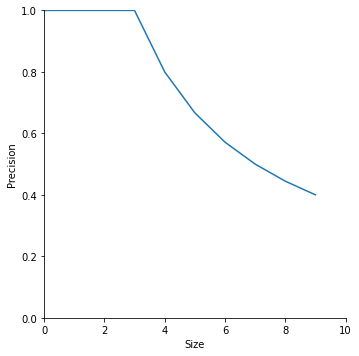

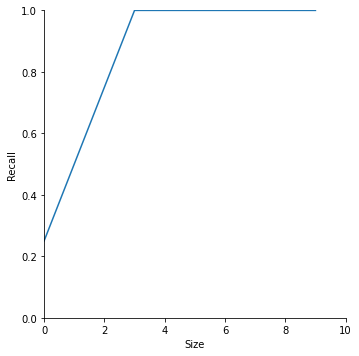

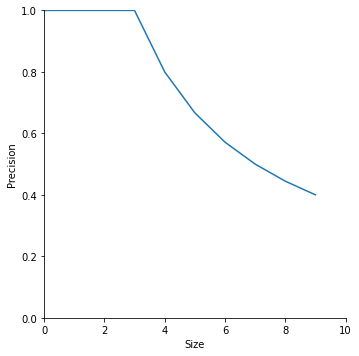

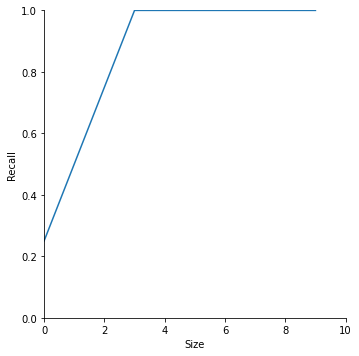

In [114]:
qrels = [
    "Constituição da República Portuguesa/2/1976-04-10T00:00:00Z",
    "Constituição da República Portuguesa/89/1976-04-10T00:00:00Z",
    "Constituição da República Portuguesa/185/1976-04-10T00:00:00Z",
    "Constituição da República Portuguesa/273/1976-04-10T00:00:00Z",
]

# schemaless
schemaless_results = requests.get(
    SCHEMALESS_URL,
    params={
        "defType": "edismax",
        "qf": "title text path",
        "q": "socialismo +date:[1976-01-01T00:00:00Z TO 1976-12-31T23:59:59Z] +book:constituicao",
        "start": 0,
        "rows": 1000
    }
).json()['response']['docs']

# schema with no weights
schema_simple_results = requests.get(
    SCHEMA_URL,
    params={
        "defType": "edismax",
        "qf": "title_raw title text_raw text path",
        "q": "socialismo +date:[1976-01-01T00:00:00Z TO 1976-12-31T23:59:59Z] +book:constituicao",
        "start": 0,
        "rows": 1000
    }
).json()['response']['docs']

# schema and weight
schema_full_results = requests.get(
    SCHEMA_URL,
    params={
        "defType": "edismax",
        "qf": "title_raw^3 title^2 text_raw^1.5 text^1 path^0.5",
        "q": "+socialismo +date:[1976-01-01T00:00:00Z TO 1976-12-31T23:59:59Z] +book:constituicao",
        "start": 0,
        "rows": 1000
    }
).json()['response']['docs']

# average precision takes the order into account
# precision at 10 is the percentage of relevant information in the top10
# recall is the percentage of relevant information in the total of results
statistics("initial const search schemaless", schemaless_results, qrels)
statistics("initial const search schema without weights",
           schema_simple_results, qrels)
statistics("initial const search schema with weights",
           schema_full_results, qrels)


## Articles with "horário flexível" in the title

title schemaless
                        0      1
0                  Metric  Value
1       Average Precision      0
2  Precision at 10 (P@10)    0.0
3                  Recall    0.0
title schema without weights
                        0         1
0                  Metric     Value
1       Average Precision  0.541569
2  Precision at 10 (P@10)       0.3
3                  Recall       1.0
title schema with weights
                        0         1
0                  Metric     Value
1       Average Precision  0.541569
2  Precision at 10 (P@10)       0.3
3                  Recall       1.0


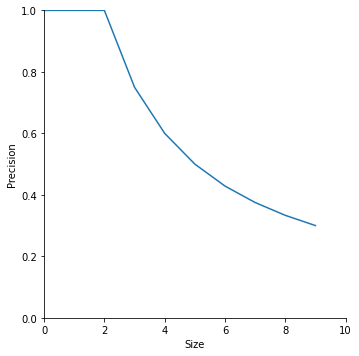

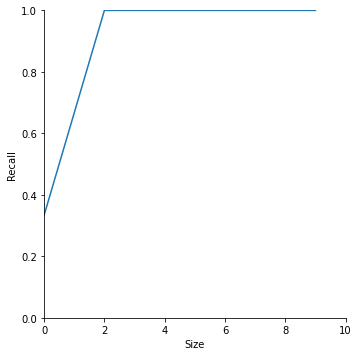

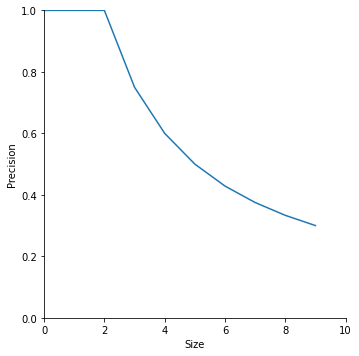

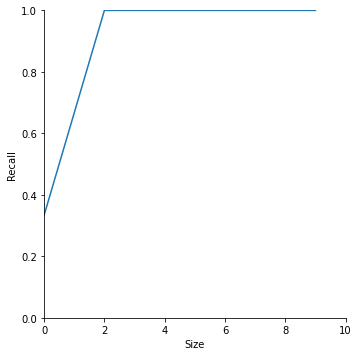

In [117]:
qrels = [
    "Código do Trabalho/56/2009-02-12T00:00:00Z",
    "Código do Trabalho/56/2015-09-06T00:00:00Z",
    "Código do Trabalho/57/2009-02-12T00:00:00Z",
]

# schemaless
schemaless_results = requests.get(
    SCHEMALESS_URL,
    params={
        "defType": "edismax",
        "bq": "state:Consolidado^4",
        "qf": "title",
        "q": "horário flexível",
        "start": 0,
        "rows": 1000
    }
).json()['response']['docs']

# schema with no weights
schema_simple_results = requests.get(
    SCHEMA_URL,
    params={
        "defType": "edismax",
        "bq": "state:Consolidado^4",
        "qf": "title_raw title",
        "q": "horário flexível",
        "start": 0,
        "rows": 1000
    }
).json()['response']['docs']

# schema and weight
schema_full_results = requests.get(
    SCHEMA_URL,
    params={
        "defType": "edismax",
        "bq": "state:Consolidado^4",
        "qf": "title_raw^1.5 title",
        "q": "horário flexível",
        "start": 0,
        "rows": 1000
    }
).json()['response']['docs']

# average precision takes the order into account
# precision at 10 is the percentage of relevant information in the top10
# recall is the percentage of relevant information in the total of results
statistics("title schemaless", schemaless_results, qrels)
statistics("title schema without weights",
           schema_simple_results, qrels)
statistics("title schema with weights", schema_full_results, qrels)


## Search for "transformar numa sociedade sem clases artigo 1 da constituicao"

Schemaless
                        0      1
0                  Metric  Value
1       Average Precision    0.0
2  Precision at 10 (P@10)    0.0
3                  Recall    0.0
Schema with no weights
                        0         1
0                  Metric     Value
1       Average Precision  0.007492
2  Precision at 10 (P@10)       0.1
3                  Recall       1.0
Schema with weights
                        0         1
0                  Metric     Value
1       Average Precision  0.007492
2  Precision at 10 (P@10)       0.1
3                  Recall       1.0


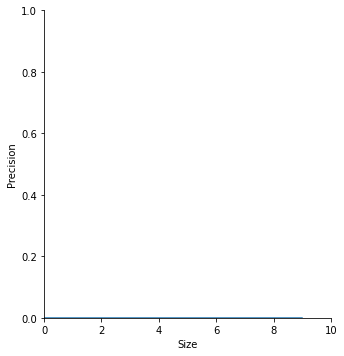

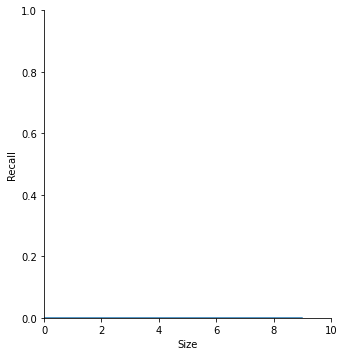

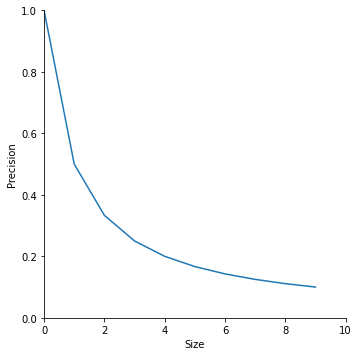

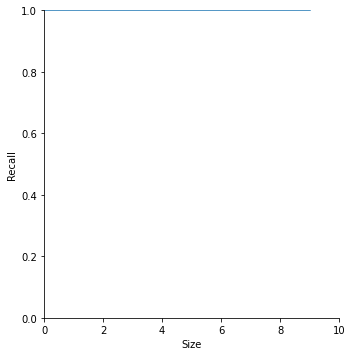

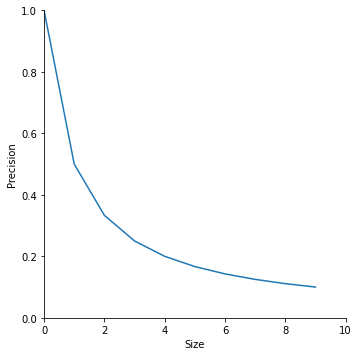

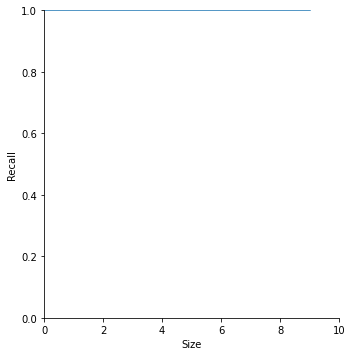

In [101]:
qrels = [
    "Constituição da República Portuguesa/1/1976-04-10T00:00:00Z"
]

# schemaless
schemaless_results = requests.get(
    SCHEMALESS_URL,
    params={
        "defType": "edismax",
        "bq": "state:Consolidado^4",
        "qf": "key title text book",
        "q": "transformar numa sociedade sem clases artigo 1 da constituicao",
        "start": 0,
        "rows": 1000
    }
).json()['response']['docs']

# schema with no weights
schema_simple_results = requests.get(
    SCHEMA_URL,
    params={
        "defType": "edismax",
        "bq": "state:Consolidado^4",
        "qf": "key title_raw title text_raw text book",
        "q": "transformar numa sociedade sem clases artigo 1 da constituicao",
        "start": 0,
        "rows": 1000
    }
).json()['response']['docs']

# schema and weight
schema_full_results = requests.get(
    SCHEMA_URL,
    params={
        "defType": "edismax",
        "bq": "state:Consolidado^4",
        "qf": "key^4 title_raw^3 title^2 text_raw^1.5 text^1 book^0.5",
        "q": "transformar numa sociedade sem clases artigo 1 da constituicao",
        "start": 0,
        "rows": 1000
    }
).json()['response']['docs']

# average precision takes the order into account
# precision at 10 is the percentage of relevant information in the top10
# recall is the percentage of relevant information in the total of results
statistics("general search schemaless", schemaless_results, qrels)
statistics("general search schema without weights",
           schema_simple_results, qrels)
statistics("general search schema with weights", schema_full_results, qrels)


## artigo 2 da constituicao

precise search schemaless
                        0      1
0                  Metric  Value
1       Average Precision    0.0
2  Precision at 10 (P@10)    0.0
3                  Recall    0.0
precise search schema without weights
                        0         1
0                  Metric     Value
1       Average Precision  0.006714
2  Precision at 10 (P@10)       0.0
3                  Recall       1.0
precise search schema with weights
                        0        1
0                  Metric    Value
1       Average Precision  0.02563
2  Precision at 10 (P@10)      0.4
3                  Recall      1.0


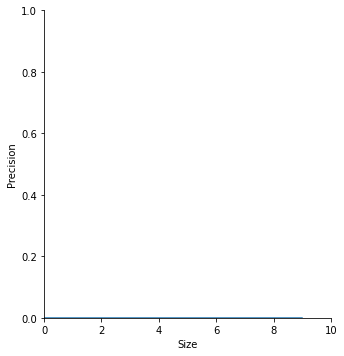

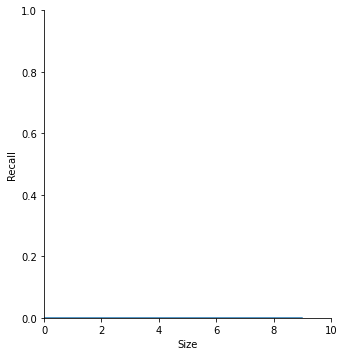

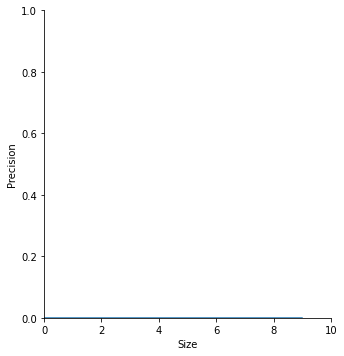

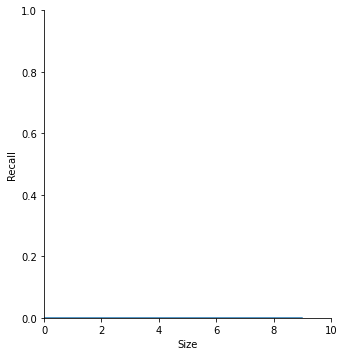

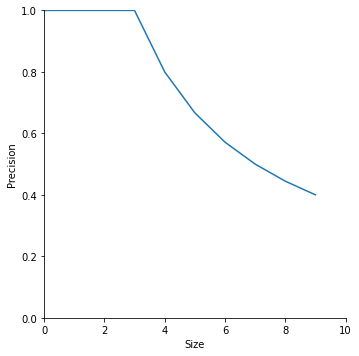

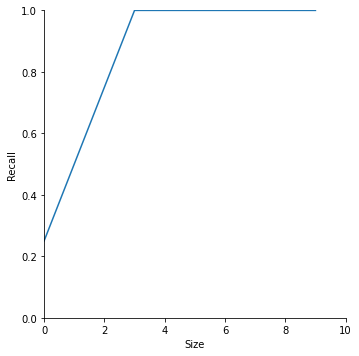

In [118]:
qrels = [
    "Constituição da República Portuguesa/2/1989-08-07T00:00:00Z",
    "Constituição da República Portuguesa/2/1976-04-10T00:00:00Z",
    "Constituição da República Portuguesa/2/1997-10-05T00:00:00Z",
    "Constituição da República Portuguesa/2/1982-10-30T00:00:00Z",
]

# schemaless
schemaless_results = requests.get(
    SCHEMALESS_URL,
    params={
        "defType": "edismax",
        "qf": "key title text path book",
        "bq": "state:Consolidado^4",
        "q": "artigo 2 da constituicau~",
        "start": 0,
        "rows": 1000
    }
).json()['response']['docs']

# schema with no weights
schema_simple_results = requests.get(
    SCHEMA_URL,
    params={
        "defType": "edismax",
        "qf": "key title_raw title text_raw text path book",
        "bq": "state:Consolidado^4",
        "q": "artigo 2 da constituicau~",
        "start": 0,
        "rows": 1000
    }
).json()['response']['docs']

# schema and weight
schema_full_results = requests.get(
    SCHEMA_URL,
    params={
        "defType": "edismax",
        "qf": "key^4 title_raw^3 title^2 text_raw^1.5 text^1 path^0.5 book^4",
        "bq": "state:Consolidado^4",
        "q": "artigo 2 da constituicau~",
        "start": 0,
        "rows": 1000
    }
).json()['response']['docs']

# average precision takes the order into account
# precision at 10 is the percentage of relevant information in the top10
# recall is the percentage of relevant information in the total of results
statistics("precise search schemaless", schemaless_results, qrels)
statistics("precise search schema without weights",
           schema_simple_results, qrels)
statistics("precise search schema with weights", schema_full_results, qrels)
